In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import sys
sys.path.append(os.path.dirname(os.getcwd()))

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from src.helper import create_and_prepare_dataset, get_data_size

In [2]:
if tf.config.list_physical_devices('GPU'):
    print("TensorFlow is using GPU")
else:
    print("TensorFlow is using CPU")

TensorFlow is using CPU


In [3]:
PROCESSED_DATA_DIR = "../data/processed"
TRAINING_DATA_DIR = "../data/split/train"
VALIDATION_DATA_DIR = "../data/split/val"
TEST_DATA_DIR = "../data/split/test"

BATCH_SIZE = 5

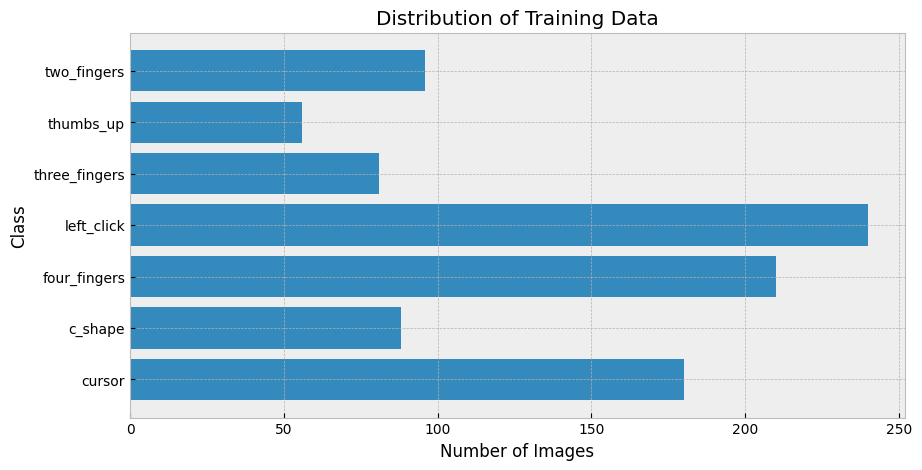

In [4]:
def plot_distribution(data_path):
    subdirs = [name for name in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, name))]
    counts = [len(os.listdir(os.path.join(data_path, subdir))) for subdir in subdirs]

    plt.style.use("bmh")
    plt.figure(figsize=(10, 5))
    plt.barh(subdirs, counts)
    plt.xlabel("Number of Images")
    plt.ylabel("Class")
    plt.title("Distribution of Training Data")
    plt.show()


plot_distribution(TRAINING_DATA_DIR)

In [5]:
training_dataset = create_and_prepare_dataset(TRAINING_DATA_DIR, BATCH_SIZE, True)
validation_dataset = create_and_prepare_dataset(VALIDATION_DATA_DIR, BATCH_SIZE)
test_dataset = create_and_prepare_dataset(TEST_DATA_DIR, BATCH_SIZE)

In [11]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(21,3)),
        tf.keras.layers.Conv1D(96, 3, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Conv1D(224, 2, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Conv1D(160, 3, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dense(352, activation='relu'),
        tf.keras.layers.Dense(576, activation='relu'),
        tf.keras.layers.Dense(7, activation='softmax')
    ])

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.0002,
        decay_steps=570,  # a step is an update of the model's weights (batch)
        decay_rate=0.9)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [12]:
def train_model(model):
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7,
                                                        restore_best_weights=True, min_delta= 0.01)

        model.fit(training_dataset,
                steps_per_epoch=None,
                validation_data=validation_dataset,
                validation_steps=None,
                epochs=50,
                callbacks=[early_stopping]
        ) 

        return model

In [13]:
model = train_model(build_model())

loss, accuracy = model.evaluate(validation_dataset)
print(f"Test accuracy: {accuracy}")
print(f"Test loss: {loss}")

Epoch 1/50


190/190 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.3485 - loss: 1.7171 - val_accuracy: 0.4400 - val_loss: 1.6525
Epoch 2/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.3938 - loss: 1.6042 - val_accuracy: 0.5200 - val_loss: 1.3259
Epoch 3/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5674 - loss: 1.2809 - val_accuracy: 0.5900 - val_loss: 1.0669
Epoch 4/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6596 - loss: 0.9645 - val_accuracy: 0.7200 - val_loss: 0.7186
Epoch 5/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7258 - loss: 0.7213 - val_accuracy: 0.7700 - val_loss: 0.7170
Epoch 6/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7948 - loss: 0.6000 - val_accuracy: 0.7850 - val_loss: 0.5920
Epoch 7/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7959 - loss: 0.5630 - val_accuracy: 0.8650 - val_loss: 0.4329
Epoch 8/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8129 - loss: 0.5010 - val_accuracy: 0.8950 - val_

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


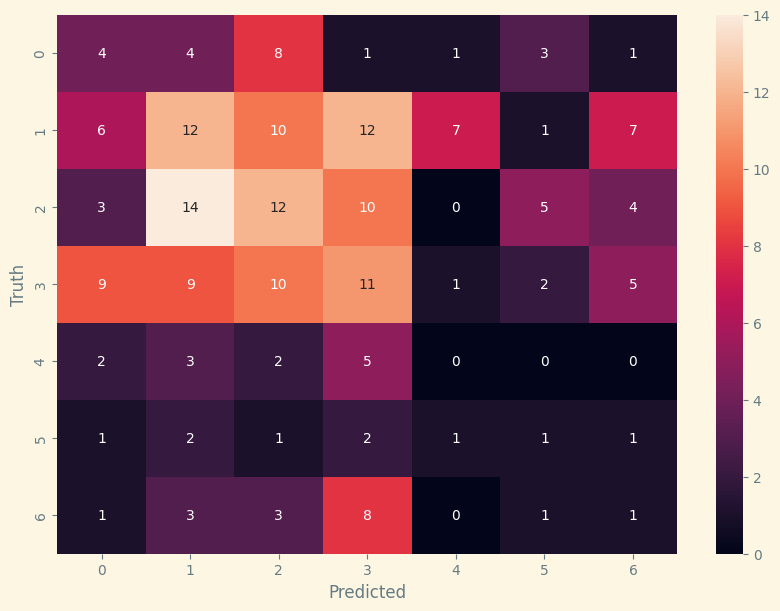

In [14]:
def plot_confusion_matrix(model, test_dataset):
    plt.style.use("Solarize_Light2")
    y_pred = np.argmax(model.predict(test_dataset), axis=-1)
    y_true = np.concatenate([y for x, y in test_dataset], axis=0)
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.show()


plot_confusion_matrix(model, test_dataset)

In [15]:
choice = input("Do you want to save the model? (y/n): ")

if choice.lower() == 'y':
    model.save(f"../models/model_acc_{accuracy:.2f}_loss_{loss:.2f}.h5")
    print("Model saved successfully!")

Model saved successfully!
